In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
try:
    os.chdir("drive/My Drive/PROJEKT/")
except FileNotFoundError:
    pass


Mounted at /content/drive/


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
from definitions import *
from new_preprocessing import load_datasets, time_footprint, load_labels_datasets, load_images_datasets
from test_preprocesing import *
import tensorflow as tf
from tensorflow import keras

### Load data sets

In [ ]:
#train_ds, test_ds, val_ds = test_load_datasets()
train_ds, test_ds, val_ds = load_datasets()

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### Load model

In [ ]:
# load model - when loading for the firt time pretrained weights are downloaded
model = VGG19()

# summarize the model
model.summary()

574717952/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
drop_layers = [23, 24, 25]

input_layer = x = model.input


for i, layer in enumerate(model.layers[1:], 1):
    if i not in drop_layers:
        x = layer(x)

        x[-1].shape
x = tf.keras.layers.Dense(1024, name="fc1")(x)
x = tf.keras.layers.Dense(1024, name="fc2")(x)
x = tf.keras.layers.Dense(4, name="predictions", activation='softmax')(x)

newVGGmodel = tf.keras.models.Model(inputs = input_layer, outputs = x)


KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
# Set layer.trainable = Flase at leayers that we don't want to train
for layer in newVGGmodel.layers[0:22]:
    layer.trainable = False

###  Validate if weights are legit

In [ ]:
# updatable plot for live loss value observation
# a minimal example (sort of)
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
#         self.accuracy.append(logs.get('binary_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
#         plt.plot(self.x, self.accuracy, label="accuracy")
        plt.legend()
        plt.show();
        
plot = PlotLosses()

In [ ]:
base_learning_rate = 1.0e-5  # 1.0e-4 2.0e-5
print(newVGGmodel.output_shape)
newVGGmodel.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss = keras.losses.CategoricalCrossentropy(),
              metrics   = ['accuracy'])

(None, 4)


In [ ]:
TRAIN_FILES//BATCH_SIZE

276

### Train 3 last layers

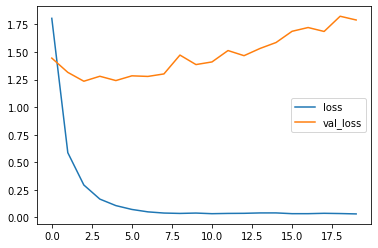

In [ ]:
epochs          = 20
steps_per_epoch = TRAIN_FILES//BATCH_SIZE
val_steps       =   VAL_FILES//BATCH_SIZE

LOG_DIR = 'logs'
MODEL_DIR = 'models'

time_fp = time_footprint()
log_dir = os.path.join(LOG_DIR, 'task_1', time_fp)
os.makedirs(log_dir)

checkpoint_path = log_dir + "/task_1" + time_fp + ".ckpt"

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       save_weights_only=False,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor='val_loss'),
    plot
]

print(train_ds)
print(val_ds)
history = newVGGmodel.fit(train_ds,
                    epochs           = epochs,
                    steps_per_epoch  = steps_per_epoch,
                    validation_data  = val_ds,
                    validation_steps  = val_steps,
                    callbacks        = callbacks
                    )


val_acc = history.history['val_accuracy'][0]

model_name = "task_1" + time_fp + '_acc_' + f'{val_acc:.4f}' + '.h5'
newVGGmodel.save(MODEL_DIR + '/' + model_name,include_optimizer=True)

In [ ]:
MODEL_DIR = 'models'
model_name = "task_1.h5"
newVGGmodel.save(MODEL_DIR + '/' + model_name,include_optimizer=True)

INFO:tensorflow:Assets written to: models/task_1attempt2with_optimizer/assets


In [ ]:
model_path = 'models/task_1attempt2_2021-01-13_21-32-31_acc_0.8924.h5'
newVGGmodel = keras.models.load_model(model_path)
newVGGmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math


tf.executing_eagerly()


#computing accuracy
loss, acc = newVGGmodel.evaluate(test_ds, steps = 85)


#preparing predictions
predictions = newVGGmodel.predict(test_ds, verbose=1, steps = None)



86/86 [==============================] - 107s 1s/step


In [ ]:
print(predictions)

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 7.1290186e-20]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [4.7189911e-20 1.0000000e+00 0.0000000e+00 3.9893887e-12]]


In [ ]:
# Prepare smaller data set
# 50 batches

test_labels = []

for images, labels in test_ds.as_numpy_iterator(): 

  labels = labels.argmax(axis=1)
  test_labels.append(labels)


In [ ]:
test_labels = np.concatenate(test_labels)

In [ ]:
predictions_classes = predictions.argmax(axis=1)
predictions_classes[0]

0

In [ ]:
import sklearn
import sklearn.metrics

# Confusion matrix for SVM with linear kernel
sklearn.metrics.confusion_matrix(test_labels, predictions_classes)

array([[5201,   78,    1,  261],
       [ 183, 4292,    7,  807],
       [  23,    7, 4820,  150],
       [ 284,  207,   31, 5597]])

In [ ]:
# Accuracy
sklearn.metrics.accuracy_score(test_labels, predictions_classes)

0.9071028292860722

In [ ]:
# Precision recall fscor support
sklearn.metrics.precision_recall_fscore_support(test_labels, predictions_classes, average="macro")

(0.9158623915968094, 0.9072066836847896, 0.9097008866751081, None)